In [1]:
# import basic utility packages
import pandas as pd
import numpy as np
np.random.seed(37)
import pickle
from datetime import datetime

# import scaling packages
from sklearn.preprocessing import StandardScaler

# import model training packages
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import deep learning model packages
import tensorflow as tf
tf.random.set_seed(89)
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import initializers
keras.utils.set_random_seed(812)

# import metrics packages
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# importing the visualization packages
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
import seaborn as sns

In [2]:
# reading the sample dataset
data = pd.read_excel('CM_ML_training_outlier_removed_MCP.xlsx')
data.head()

,PL_L_x,PL_L_y,PL_R_x,PL_R_y,PM_x,PM_y,PP_x,CM_x,CM_y,CM_z
0,-1.815,-11.0550,0.943,-11.1890,-12.293,16.6940,-31.274,-9.14906,-8.0959,3.63316
1,-1.145,-13.5190,2.833,-13.5000,-12.131,19.0860,-31.268,-8.01396,-10.7875,4.96688
2,-1.015,-11.7780,2.831,-11.8420,-13.644,19.4630,-27.789,-7.14325,-8.6361,3.59335
3,-0.611,-11.7595,1.502,-11.7665,-11.947,19.7555,-29.556,-6.95394,-8.2071,4.12057
4,-1.495,-12.2810,0.700,-12.3120,-12.174,17.5510,-28.750,-7.68525,-9.5389,4.13434


In [3]:
# separating the independent and dependent variables
xData = data[['PL_L_x', 'PL_L_y', 'PL_R_x', 'PL_R_y', 'PM_x', 'PM_y', 'PP_x']]
yData = data[['CM_x', 'CM_y', 'CM_z']]

In [4]:
# train-test split
xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, random_state = 0, test_size = 0.25, shuffle = True)

# resetting the indices
xTrain.reset_index(inplace = True, drop = True)
xTest.reset_index(inplace = True, drop = True)
yTrain.reset_index(inplace = True, drop = True)
yTest.reset_index(inplace = True, drop = True)

xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((146, 7), (49, 7), (146, 3), (49, 3))

In [5]:
# performing standard scaling
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = pd.DataFrame(scaler.transform(xTrain), columns = xData.columns)
xTest = pd.DataFrame(scaler.transform(xTest), columns = xData.columns)

In [6]:
def printMetrics(yOriginal, yPred, label):
    mse = mean_squared_error(yOriginal, yPred)
    print(label + " MSE : " + str(mse))
    return

def featureSelectionRFE(model, x, y, numFeatures, isTrain = False):
    rfe = RFE(model, numFeatures)
    xRFE = rfe.fit_transform(x, y)
    return xRFE, rfe

def runAnalysis(model, xTrain, yTrain, xTest, yTest, modelName):
    print("<<----------------------------------------->>\n")        
    print(modelName + " Performance Metrics :")
    model.fit(xTrain, yTrain)
    yPredTrain = model.predict(xTrain)
    printMetrics(yTrain, yPredTrain, "Train")
    print("Train Model Score : " + str(model.score(xTrain, yTrain)))
    yPredTest = model.predict(xTest)
    printMetrics(yTest, yPredTest, "Test")
    print("Test Model Score : " + str(model.score(xTest, yTest)))
    print("\n<<----------------------------------------->>")
    return

In [7]:
# sequential Neural Network
modelX = Sequential()

# input Layer :
modelX.add(Dense(36, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), input_dim = xTrain.shape[1], activation = 'relu'))

# hidden Layers :
modelX.add(Dense(70, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))

# output Layer :
modelX.add(Dense(1, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), activation = 'linear'))

# compile the network :
modelX.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse', 'mae'])
# NN_model.summary()

# train the model :
modelX.fit(xTrain, yTrain['CM_x'], epochs = 200, validation_data = (xTest, yTest['CM_x']), verbose = 0)

# predicting the train data 
yPredTrain = pd.DataFrame(modelX.predict(xTrain), columns = ['CM_x_pred'])

# consolidated train data
dataTrainX = pd.concat([xTrain, yTrain, yPredTrain], axis = 1)
dataTrainX.head()

# metrics calculations for train data
mseXTrain = mean_squared_error(dataTrainX['CM_x'], dataTrainX['CM_x_pred'])
print("Train MSE X: " + str(mseXTrain))

# predicting the test data 
yPredTest = pd.DataFrame(modelX.predict(xTest), columns = ['CM_x_pred'])

# consolidated test data
dataTestX = pd.concat([xTest, yTest, yPredTest], axis = 1)
dataTestX.head()

# metrics calculations for test data
mseXTest = mean_squared_error(dataTestX['CM_x'], dataTestX['CM_x_pred'])
print("Test MSE X: " + str(mseXTest))

# error calculation as per stereotaxy 
error_x = np.mean(np.abs(dataTrainX['CM_x'] - dataTrainX['CM_x_pred']))
print(f"Mean Train stereotactic X error: {error_x:.2f} mm")
error_x = np.mean(np.abs(dataTestX['CM_x'] - dataTestX['CM_x_pred']))
print(f"Mean Test stereotactic X error: {error_x:.2f} mm")

# print metrics
printMetrics(yTrain['CM_x'], yPredTrain, label = "Train")
printMetrics(yTest['CM_x'], yPredTest, label = "Test")

/Users/hargun/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MSE X: 0.21813238105369487
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
Test MSE X: 0.32061607158773364
Mean Train stereotactic X error: 0.37 mm
Mean Test stereotactic X error: 0.48 mm
Train MSE : 0.21813238105369487
Test MSE : 0.32061607158773364


In [8]:
# sequential Neural Network
modelY = Sequential()

# input Layer :
modelY.add(Dense(38, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), input_dim = xTrain.shape[1], activation = 'relu'))

# hidden Layers :
modelY.add(Dense(86, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))

# output Layer :
modelY.add(Dense(1, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), activation = 'linear'))

# compile the network :
modelY.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse', 'mae'])
# NN_model.summary()

# train the model :
modelY.fit(xTrain, yTrain['CM_y'], epochs = 200, validation_data = (xTest, yTest['CM_y']), verbose = 0)

# predicting the train data 
yPredTrain = pd.DataFrame(modelY.predict(xTrain), columns = ['CM_y_pred'])

# consolidated train data
dataTrainY = pd.concat([xTrain, yTrain, yPredTrain], axis = 1)
dataTrainY.head()

# metrics calculations for train data
mseYTrain = mean_squared_error(dataTrainY['CM_y'], dataTrainY['CM_y_pred'])
print("Train MSE Y: " + str(mseYTrain))

# predicting the test data 
yPredTest = pd.DataFrame(modelY.predict(xTest), columns = ['CM_y_pred'])

# consolidated test data
dataTestY = pd.concat([xTest, yTest, yPredTest], axis = 1)
dataTestY.head()

# metrics calculations for test data
mseXTest = mean_squared_error(dataTestY['CM_y'], dataTestY['CM_y_pred'])
print("Test MSE X: " + str(mseXTest))

# error calculation as per stereotaxy 
error_x = np.mean(np.abs(dataTrainY['CM_y'] - dataTrainY['CM_y_pred']))
print(f"Mean Train stereotactic Y error: {error_x:.2f} mm")
error_x = np.mean(np.abs(dataTestY['CM_y'] - dataTestY['CM_y_pred']))
print(f"Mean Test stereotactic Y error: {error_x:.2f} mm")

# print metrics
printMetrics(yTrain['CM_y'], yPredTrain, label = "Train")
printMetrics(yTest['CM_y'], yPredTest, label = "Test")

/Users/hargun/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train MSE Y: 0.36059367172408774
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
Test MSE X: 0.49421972871268816
Mean Train stereotactic Y error: 0.47 mm
Mean Test stereotactic Y error: 0.58 mm
Train MSE : 0.36059367172408774
Test MSE : 0.49421972871268816


In [9]:
# sequential Neural Network
modelZ = Sequential()

# input Layer :
modelZ.add(Dense(17, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), input_dim = xTrain.shape[1], activation = 'relu'))

# hidden Layers :
modelZ.add(Dense(90, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))
# NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu'))

# output Layer :
modelZ.add(Dense(1, kernel_initializer = initializers.RandomNormal(seed = 42), 
                   bias_initializer = initializers.RandomNormal(seed = 42), activation = 'linear'))

# compile the network :
modelZ.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse', 'mae'])
# NN_model.summary()

# train the model :
modelZ.fit(xTrain, yTrain['CM_z'], epochs = 200, validation_data = (xTest, yTest['CM_z']), verbose = 0)

# predicting the train data 
yPredTrain = pd.DataFrame(modelZ.predict(xTrain), columns = ['CM_z_pred'])

# consolidated train data
dataTrainZ = pd.concat([xTrain, yTrain, yPredTrain], axis = 1)
dataTrainZ.head()

# metrics calculations for train data
mseZTrain = mean_squared_error(dataTrainZ['CM_z'], dataTrainZ['CM_z_pred'])
print("Train MSE Y: " + str(mseZTrain))

# predicting the test data 
yPredTest = pd.DataFrame(modelZ.predict(xTest), columns = ['CM_z_pred'])

# consolidated test data
dataTestZ = pd.concat([xTest, yTest, yPredTest], axis = 1)
dataTestZ.head()

# metrics calculations for test data
mseZTest = mean_squared_error(dataTestZ['CM_z'], dataTestZ['CM_z_pred'])
print("Test MSE Z: " + str(mseZTest))

# error calculation as per stereotaxy 
error_x = np.mean(np.abs(dataTrainZ['CM_z'] - dataTrainZ['CM_z_pred']))
print(f"Mean Train stereotactic Z error: {error_x:.2f} mm")
error_x = np.mean(np.abs(dataTestZ['CM_z'] - dataTestZ['CM_z_pred']))
print(f"Mean Test stereotactic Z error: {error_x:.2f} mm")

# print metrics
printMetrics(yTrain['CM_z'], yPredTrain, label = "Train")
printMetrics(yTest['CM_z'], yPredTest, label = "Test")

/Users/hargun/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE Y: 0.2676964193276093
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
Test MSE Z: 0.5704171009940501
Mean Train stereotactic Z error: 0.40 mm
Mean Test stereotactic Z error: 0.61 mm
Train MSE : 0.2676964193276093
Test MSE : 0.5704171009940501


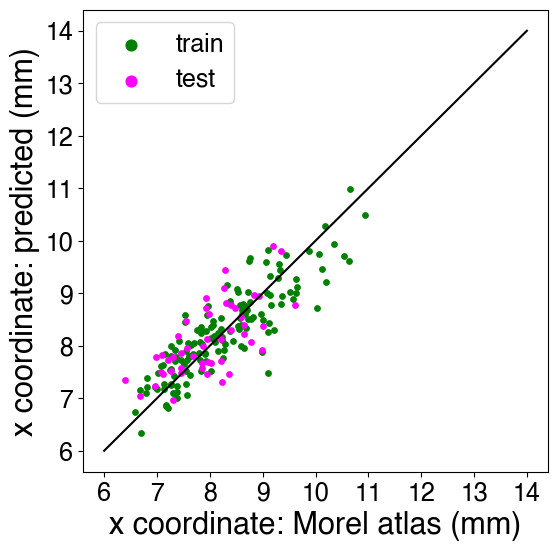

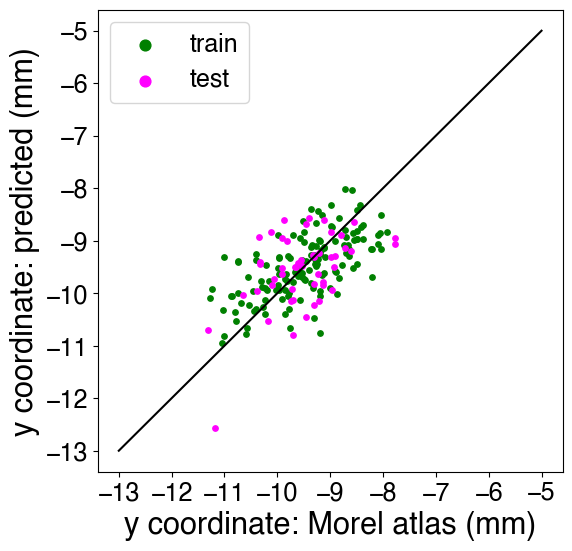

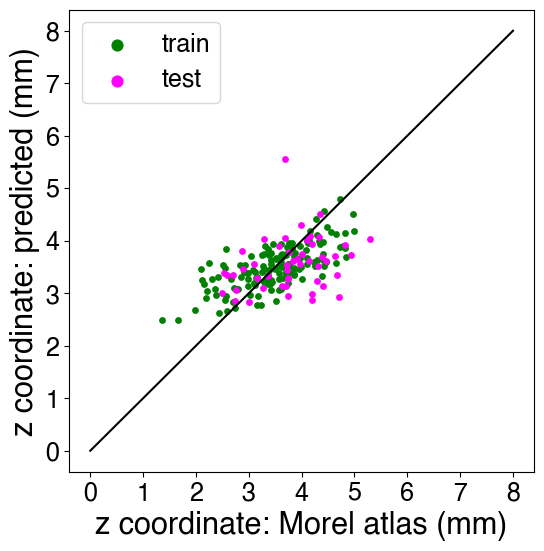

In [10]:
# CM_x scatter
plt.figure(figsize=(6, 6))
plt.scatter(abs(dataTrainX['CM_x']), abs(dataTrainX['CM_x_pred']), s=15, color='green')
plt.scatter(abs(dataTestX['CM_x']), abs(dataTestX['CM_x_pred']), s=15, color='magenta')
plt.plot(np.arange(6, 15), np.arange(6, 15), 'k-')  # 'k-' is for black solid line
plt.legend(['train', 'test'], fontsize=18, markerscale=2)
plt.xlabel('x coordinate: Morel atlas (mm)', fontsize=22)
plt.ylabel('x coordinate: predicted (mm)', fontsize=22)
plt.xticks(np.arange(6, 15, 1), fontsize=18) 
plt.yticks(np.arange(6, 15, 1), fontsize=18) 
plt.show()

# CM_y scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(dataTrainY['CM_y'], dataTrainY['CM_y_pred'], s=15, color='green')
plt.scatter(dataTestY['CM_y'], dataTestY['CM_y_pred'], s=15, color='magenta')
plt.plot(np.arange(-13, -4), np.arange(-13, -4), 'k-')
plt.legend(['train', 'test'], fontsize=18, markerscale=2)
plt.xlabel('y coordinate: Morel atlas (mm)', fontsize=22)
plt.ylabel('y coordinate: predicted (mm)', fontsize=22)
plt.xticks(np.arange(-13, -4, 1), fontsize=18) 
plt.yticks(np.arange(-13, -4, 1), fontsize=18) 
plt.show()

# CM_z scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(dataTrainZ['CM_z'], dataTrainZ['CM_z_pred'], s=15, color='green')
plt.scatter(dataTestZ['CM_z'], dataTestZ['CM_z_pred'], s=15, color='magenta')
plt.plot(np.arange(0, 9), np.arange(0, 9), 'k-')
plt.legend(['train', 'test'], fontsize=18, markerscale=2)
plt.xlabel('z coordinate: Morel atlas (mm)', fontsize=22)
plt.ylabel('z coordinate: predicted (mm)', fontsize=22)
plt.xticks(np.arange(0, 9, 1), fontsize=18) 
plt.yticks(np.arange(0, 9, 1), fontsize=18) 
plt.show()

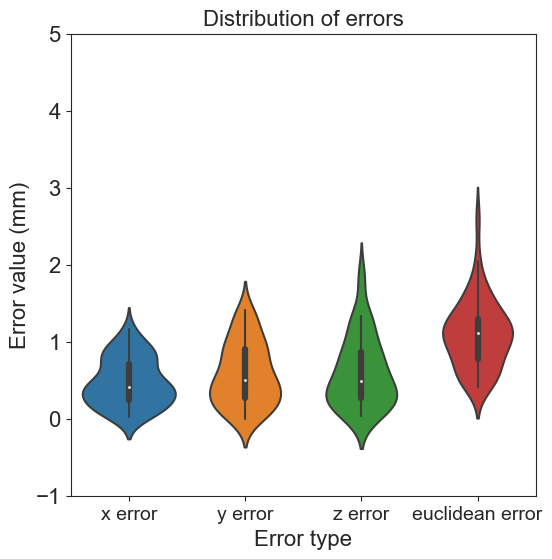

Mean Absolute Error x: 0.477 mm
Mean Absolute Error y: 0.579 mm
Mean Absolute Error z: 0.606 mm
Mean Euclidean Error: 1.092 mm
STD x: 0.306 mm
STD y: 0.398 mm
STD z: 0.451 mm
StdDev Euclidean: 0.438 mm


In [11]:
data['x error'] = np.abs(dataTestX['CM_x'] - dataTestX['CM_x_pred'])
data['y error'] = np.abs(dataTestY['CM_y'] - dataTestY['CM_y_pred'])
data['z error'] = np.abs(dataTestZ['CM_z'] - dataTestZ['CM_z_pred'])

# Calculate Euclidean error
data['euclidean error'] = np.sqrt((dataTestX['CM_x'] - dataTestX['CM_x_pred'])**2 + 
                                  (dataTestY['CM_y'] - dataTestY['CM_y_pred'])**2 + 
                                  (dataTestZ['CM_z'] - dataTestZ['CM_z_pred'])**2)

# Preparing data for violin plot
error_data = pd.melt(data, value_vars=['x error', 'y error', 'z error', 'euclidean error'],
                     var_name='Error Type', value_name='Error Value')

# Plotting
sns.set_style("ticks")
plt.figure(figsize=(6, 6))
sns.violinplot(x='Error Type', y='Error Value', data=error_data)
plt.title('Distribution of errors', fontsize=16)
plt.ylabel('Error value (mm)', fontsize=16)
plt.xlabel('Error type', fontsize=16)
plt.ylim(-1, 5)  # Set y-axis limits from 0 to 6
plt.xticks(fontsize=14)
plt.yticks(fontsize=16)
plt.show()

# Mean errors value
from sklearn.metrics import mean_absolute_error
maex = mean_absolute_error(dataTestX['CM_x'], dataTestX['CM_x_pred'])
maey = mean_absolute_error(dataTestY['CM_y'], dataTestY['CM_y_pred'])
maez = mean_absolute_error(dataTestZ['CM_z'], dataTestZ['CM_z_pred'])
print(f"Mean Absolute Error x: {maex:.3f} mm")
print(f"Mean Absolute Error y: {maey:.3f} mm")
print(f"Mean Absolute Error z: {maez:.3f} mm")
distances = np.sqrt((dataTestX['CM_x'] - dataTestX['CM_x_pred'])**2 +
                    (dataTestY['CM_y'] - dataTestY['CM_y_pred'])**2 +
                    (dataTestZ['CM_z'] - dataTestZ['CM_z_pred'])**2)

# Mean errors value
# Calculate mean of these distances
mean_euclidean_error = np.mean(distances)

print(f"Mean Euclidean Error: {mean_euclidean_error:.3f} mm")

# Calculate Standard Deviation
stdx = np.std(data['x error'])
stdy = np.std(data['y error'])
stdz = np.std(data['z error'])
print(f"STD x: {stdx:.3f} mm")
print(f"STD y: {stdy:.3f} mm")
print(f"STD z: {stdz:.3f} mm")

stdEuclidean = np.std(data['euclidean error'])
print(f"StdDev Euclidean: {stdEuclidean:.3f} mm")

In [12]:
finalDataFrame = pd.concat([pd.concat([xTrain, xTest]), 
                            pd.concat([dataTrainX['CM_x'], dataTestX['CM_x']]),
                            pd.concat([dataTrainY['CM_y'], dataTestY['CM_y']]),
                            pd.concat([dataTrainZ['CM_z'], dataTestZ['CM_z']]),
                            pd.concat([dataTrainX['CM_x_pred'], dataTestX['CM_x_pred']]),
                            pd.concat([dataTrainY['CM_y_pred'], dataTestY['CM_y_pred']]),
                            pd.concat([dataTrainZ['CM_z_pred'], dataTestZ['CM_z_pred']]),
                           ], axis = 1)
finalDataFrame.to_excel('NN_Results.xlsx')

In [13]:
def stereoTaxyErrorList(original, predicted):
    return np.abs(original - predicted)

xError = stereoTaxyErrorList(finalDataFrame['CM_x'], finalDataFrame['CM_x_pred'])
yError = stereoTaxyErrorList(finalDataFrame['CM_y'], finalDataFrame['CM_y_pred'])
zError = stereoTaxyErrorList(finalDataFrame['CM_z'], finalDataFrame['CM_z_pred'])
euclError = np.sqrt(xError**2 + yError**2 + zError**2)

xError.to_csv('tempx.csv')
yError.to_csv('tempy.csv')
zError.to_csv('tempz.csv')
euclError.to_csv('tempe.csv')

In [14]:
# Reading the real world data :
dataReal = pd.read_excel('CM_ML_LGS_MCP_0529.xlsx')
dataReal.head()

,PL_L_x,PL_L_y,PL_R_x,PL_R_y,PM_x,PM_y,PP_x,CM_x,CM_y,CM_z
0,-2.344,-10.54950,2.930,-10.54950,-14.142,14.99950,-30.411,-7.992224,-8.427221,3.535291
1,-3.508,-10.93150,2.689,-10.69750,-16.018,15.37450,-31.567,-8.923664,-8.384424,3.286038
2,-1.434,-10.51400,1.302,-10.57400,-13.897,17.55600,-29.888,-8.359592,-7.732065,4.676391
3,-0.891,-11.38400,1.377,-11.54600,-12.072,16.73100,-28.601,-6.974113,-6.824803,3.957301
4,-2.171,-11.19775,1.942,-11.42675,-15.769,15.08225,-28.566,-7.403554,-9.331680,2.602645


In [15]:
# separating the independent and dependent variables
xData = dataReal[['PL_L_x', 'PL_L_y', 'PL_R_x', 'PL_R_y', 'PM_x', 'PM_y','PP_x']]
yData = dataReal[['CM_x', 'CM_y', 'CM_z']]

In [16]:
dataReal.to_excel('DNN_Real_Results.xlsx')

In [17]:
# Reading the real world data :
dataReal = pd.read_excel('CM_ML_LGS_MCP_0529.xlsx')
dataReal.head()

# separating the independent and dependent variables
xData = dataReal[['PL_L_x', 'PL_L_y', 'PL_R_x', 'PL_R_y', 'PM_x', 'PM_y','PP_x']]
yData = dataReal[['CM_x', 'CM_y', 'CM_z']]

# Perform standard scaling on real data
xData = pd.DataFrame(scaler.transform(xData), columns=xData.columns)

# Using on the real values :
dataReal['xPred'] = modelX.predict(xData).flatten()
dataReal['yPred'] = modelY.predict(xData).flatten()
dataReal['zPred'] = modelZ.predict(xData).flatten()

# metrics calculations for real data
mseX = mean_squared_error(dataReal['CM_x'], dataReal['xPred'])
mseY = mean_squared_error(dataReal['CM_y'], dataReal['yPred'])
mseZ = mean_squared_error(dataReal['CM_z'], dataReal['zPred'])

print("Real MSE X: " + str(mseX))
print("Real MSE Y: " + str(mseY))
print("Real MSE Z: " + str(mseZ))

dataReal.to_excel('DNN_Real_Results.xlsx')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
Real MSE X: 1.5357931319652285
Real MSE Y: 3.6186418138018497
Real MSE Z: 0.4018965542163162


In [18]:
def stereoTaxyErrorList(original, predicted):
    return np.abs(original - predicted)

xError = stereoTaxyErrorList(dataReal['CM_x'], dataReal['xPred'])
yError = stereoTaxyErrorList(dataReal['CM_y'], dataReal['yPred'])
zError = stereoTaxyErrorList(dataReal['CM_z'], dataReal['zPred'])
euclError = np.sqrt(xError**2 + yError**2 + zError**2)

xError.to_csv('tempx.csv')
yError.to_csv('tempy.csv')
zError.to_csv('tempz.csv')
euclError.to_csv('tempe.csv')